In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

## 处理数据

In [2]:
# 绘制混淆矩阵
def plot_confusion_matrix(y_test, y_pred):
    """绘制混淆矩阵"""
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [3]:
usecols = [
    "yield_daliy",
    "activity_daliy",
    "chew_daliy",
    "lactation_days",
    "lactation_period",
    "disease_status",
]
data = pd.read_csv("../data/sample_test.csv", usecols=usecols)
data["disease_status"].value_counts()

乳房疾病      634
生殖系统      423
自定义疾病     244
消化系统       51
营养代谢系统     46
传染病        18
应激与过敏      15
神经系统        6
四肢疾病        4
泌尿系统        1
Name: disease_status, dtype: int64

In [4]:
data.info()
data.describe()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188572 entries, 0 to 188571
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   yield_daliy       188572 non-null  float64
 1   activity_daliy    188486 non-null  float64
 2   chew_daliy        188572 non-null  float64
 3   lactation_days    188572 non-null  int64  
 4   lactation_period  188572 non-null  int64  
 5   disease_status    1442 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 8.6+ MB


,yield_daliy,activity_daliy,chew_daliy,lactation_days,lactation_period,disease_status
0,36.905998,386.0,635.0,16,5,NaN
1,40.021999,393.0,654.0,17,5,NaN
2,39.776001,410.0,665.0,18,5,NaN
3,41.172001,382.0,564.0,19,5,NaN
4,38.122002,383.0,393.0,20,5,NaN
...,...,...,...,...,...,...
188567,6.160000,422.0,113.0,0,1,NaN
188568,7.500000,607.0,245.0,1,1,NaN
188569,14.750000,526.0,474.0,2,1,NaN
188570,9.230000,525.0,632.0,3,1,NaN


In [5]:
# 删除非常见的疾病类型
del_dis = ["传染病", "应激与过敏", "神经系统", "四肢疾病", "泌尿系统"]
for dis in del_dis:
    data.drop(data[data["disease_status"] == dis.strip()].index, axis=0, inplace=True)

data["disease_status"].value_counts()

乳房疾病      634
生殖系统      423
自定义疾病     244
消化系统       51
营养代谢系统     46
Name: disease_status, dtype: int64

In [6]:
# 替换为 0/1
data["disease_status"].fillna(0, inplace=True)
data["disease_status"] = data["disease_status"].apply(lambda x: 1 if x else 0)
data["disease_status"].value_counts(normalize=True)

0    0.992585
1    0.007415
Name: disease_status, dtype: float64

In [7]:
# 正负样本
data_0 = data[data["disease_status"] == 0]
data_1 = data[data["disease_status"] == 1]

# 选择 3000 个负样本
index_0 = np.random.choice(data_0.shape[0], 3000)

data_0.iloc[index_0]

,yield_daliy,activity_daliy,chew_daliy,lactation_days,lactation_period,disease_status
11959,45.544998,443.0,512.0,88,6,0
165594,50.339001,458.0,517.0,188,1,0
43428,20.510000,438.0,560.0,245,3,0
120161,46.633999,557.0,615.0,71,2,0
23935,49.997002,566.0,603.0,240,5,0
...,...,...,...,...,...,...
129706,0.000000,615.0,564.0,0,2,0
28723,7.256000,433.0,514.0,279,5,0
61734,38.740002,463.0,673.0,259,3,0
68371,25.410000,450.0,606.0,644,2,0


## 训练模型

In [8]:
data.dropna(inplace=True)
y = data[["disease_status"]]
X = data.drop("disease_status", axis=1)

SEED = 666

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

In [9]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(pd.DataFrame(X_test))

In [10]:
def plot_AUC(model, X_test, y_test):
    """绘制 AUC 曲线"""
    probs = model.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

def make_brf_modle(X_train, y_train, X_test, y_test):
    BRF = BalancedRandomForestClassifier(
        n_estimators=5,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=2,
        min_weight_fraction_leaf=0,
        max_features="auto",
        min_impurity_decrease=0,
        bootstrap=True,
        oob_score=False,
        sampling_strategy="auto",
        replacement=False,
        n_jobs=1,
        random_state=SEED,
        verbose=2,
        warm_start=False,
        class_weight=None,
    )
    BRF.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,BRF.predict(X_test))}")

    return BRF


def make_bbc_model(X_train, y_train, X_test, y_test):
    bbc = BalancedBaggingClassifier(
        estimator=DecisionTreeClassifier(),
        sampling_strategy="auto",
        replacement=True,
        random_state=SEED,
    )
    bbc.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,bbc.predict(X_test))}")
    return bbc

## BalancedBaggingClassifier

In [11]:
# bbc = make_bbc_model(X_train, y_train, X_test, y_test)
bbc = make_bbc_model(X_train_std, y_train, X_test_std, y_test)

d:\Program\Python3.10\lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score:              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56114
           1       0.07      0.77      0.12       419

    accuracy                           0.92     56533
   macro avg       0.53      0.85      0.54     56533
weighted avg       0.99      0.92      0.95     56533



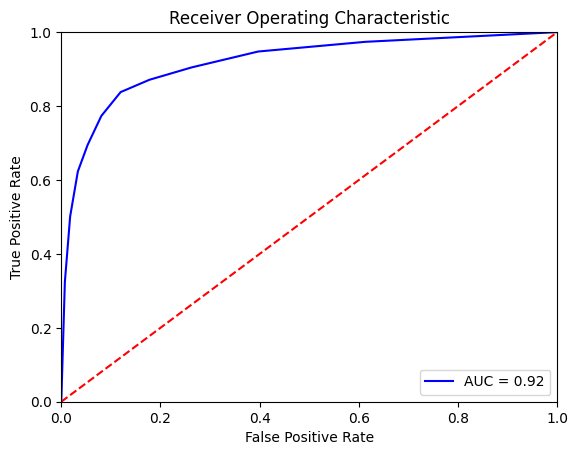

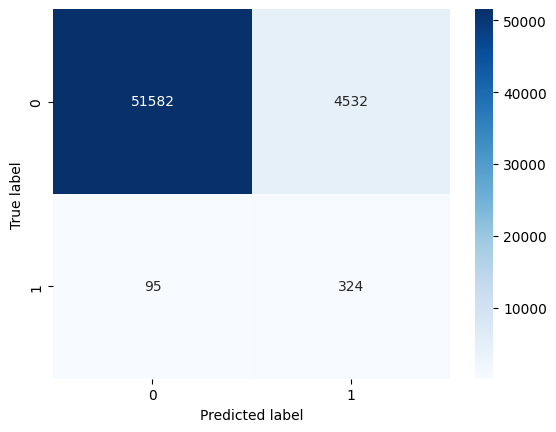

In [12]:
# plot_AUC(bbc, X_test, y_test)
# plot_confusion_matrix(y_test, bbc.predict(X_test))
plot_AUC(bbc, X_test_std, y_test)
plot_confusion_matrix(y_test, bbc.predict(X_test_std))

## BalancedRandomForestClassifier

In [13]:
# brf = make_brf_modle(X_train, y_train, X_test, y_test)
brf = make_brf_modle(X_train_std, y_train, X_test_std, y_test)

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
score:              precision    recall  f1-score   support

           0       1.00      0.85      0.92     56114
           1       0.04      0.82      0.07       419

    accuracy                           0.85     56533
   macro avg       0.52      0.83      0.50     56533
weighted avg       0.99      0.85      0.91     56533



C:\Users\10069\AppData\Local\Temp\ipykernel_11380\2399802099.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  BRF.fit(X_train, y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
d:\Program\Python3.10\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
d:\Program\Python3.10\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
d:\Program\Python3.10\lib\site-packages\sklearn\tree\_classes.py:269: F

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


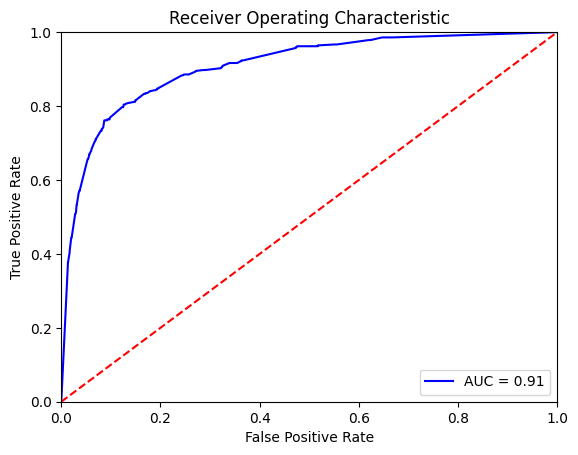

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


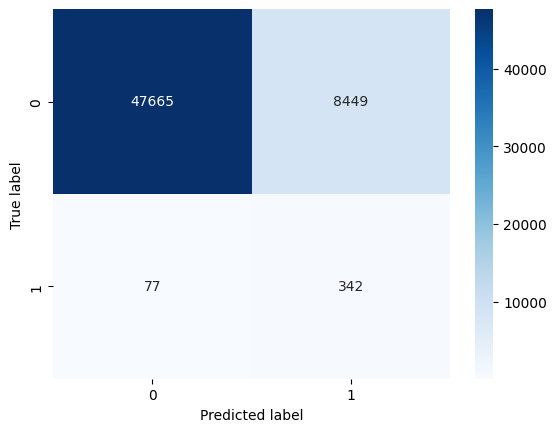

In [14]:
# plot_AUC(brf, X_test, y_test)
# plot_confusion_matrix(y_test, brf.predict(X_test))
plot_AUC(brf, X_test_std, y_test)
plot_confusion_matrix(y_test, brf.predict(X_test_std))

## XGBClassifier

In [15]:
def make_xgb_model(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier(
        eval_metrics=["logloss", "auc", "error"],
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.7,
        objective="binary:logistic",
        scale_pos_weight=1000,
        nthread=4,
        seed=SEED,
    )
    xgb.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,xgb.predict(X_test))}")
    return xgb

In [16]:
# xgb = make_xgb_model(X_train, y_train, X_test, y_test)
xgb = make_xgb_model(X_train_std, y_train, X_test_std, y_test)

[23:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "eval_metrics" } are not used.

score:              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56114
           1       0.08      0.76      0.15       419

    accuracy                           0.93     56533
   macro avg       0.54      0.85      0.56     56533
weighted avg       0.99      0.93      0.96     56533



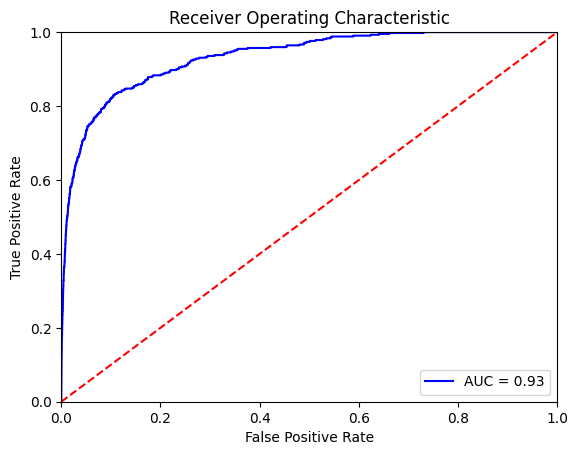

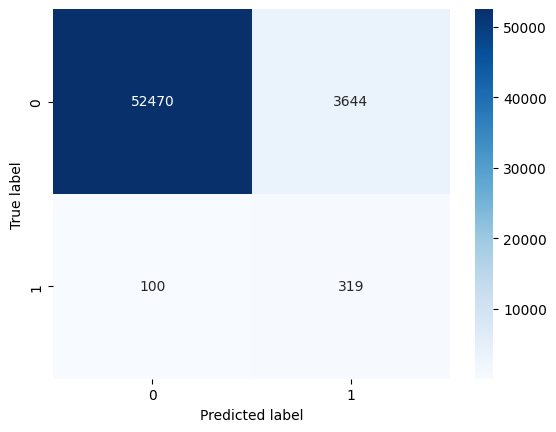

In [17]:
# plot_AUC(xgb, X_test, y_test)
# plot_confusion_matrix(y_test, xgb.predict(X_test))
plot_AUC(xgb, X_test_std, y_test)
plot_confusion_matrix(y_test, xgb.predict(X_test_std))

## 疾病分类

In [18]:
data2 = pd.read_csv("../data/sample_test.csv", usecols=usecols)

In [19]:
data2_notnull = data2[data2["disease_status"].notnull()]
data2_notnull

,yield_daliy,activity_daliy,chew_daliy,lactation_days,lactation_period,disease_status
928,22.277000,510.0,430.0,36,5,乳房疾病
929,16.101999,496.0,373.0,37,5,乳房疾病
930,29.773001,484.0,515.0,38,5,乳房疾病
931,39.073002,506.0,541.0,39,5,乳房疾病
1622,19.900000,428.0,564.0,51,5,乳房疾病
...,...,...,...,...,...,...
186917,13.850000,486.0,394.0,19,1,生殖系统
186996,39.389999,539.0,563.0,24,1,生殖系统
186997,34.597000,536.0,657.0,25,1,生殖系统
186998,35.306999,513.0,638.0,26,1,生殖系统


In [20]:
del_dis = ["传染病", "应激与过敏", "神经系统", "四肢疾病", "泌尿系统"]
for dis in del_dis:
    data2_notnull.drop(
        data2_notnull[data2_notnull["disease_status"] == dis].index,
        axis=0,
        inplace=True,
    )
data2_notnull["disease_status"].value_counts()

C:\Users\10069\AppData\Local\Temp\ipykernel_11380\2621545667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_notnull.drop(


乳房疾病      634
生殖系统      423
自定义疾病     244
消化系统       51
营养代谢系统     46
Name: disease_status, dtype: int64

In [21]:
dt = {v: k for k, v in enumerate(data2_notnull["disease_status"].unique())}
dt

{'乳房疾病': 0, '消化系统': 1, '自定义疾病': 2, '生殖系统': 3, '营养代谢系统': 4}

In [22]:
data2_notnull["cls"] = data2_notnull["disease_status"].map(dt)
data_dis = data2_notnull.drop(columns="disease_status")
data_dis["cls"].value_counts()

C:\Users\10069\AppData\Local\Temp\ipykernel_11380\1305538953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_notnull["cls"] = data2_notnull["disease_status"].map(dt)


0    634
3    423
2    244
1     51
4     46
Name: cls, dtype: int64

构建分类模型，将疾病分为以下几类：

0. 乳房疾病
1. 消化系统
2. 自定义疾病
3. 生殖系统
4. 营养代谢系统

In [23]:
data_dis.dropna(axis=0, inplace=True)
X_dis = data_dis.drop(columns="cls")
y_dis = data_dis["cls"]

X_train_dis, X_test_dis, y_train_dis, y_test_dis = train_test_split(
    X_dis, y_dis, test_size=0.2, random_state=SEED
)

X_train_std = scaler.fit_transform(X_train_dis)
X_test_std = scaler.transform(X_test_dis)

In [24]:
def plot_confusion_matrix_multi(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap="Blues")
    plt.colorbar()
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(
                cm[x, y],
                xy=(x, y),
                horizontalalignment="center",
                verticalalignment="center",
            )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

## BalanceBaggingClassifier

In [25]:
bbc = make_bbc_model(X_train_std, y_train_dis, X_test_std, y_test_dis)

score:              precision    recall  f1-score   support

           0       0.84      0.63      0.72       138
           1       0.41      0.64      0.50        11
           2       0.57      0.59      0.58        46
           3       0.80      0.77      0.79        74
           4       0.19      0.73      0.30        11

    accuracy                           0.66       280
   macro avg       0.56      0.67      0.58       280
weighted avg       0.75      0.66      0.69       280



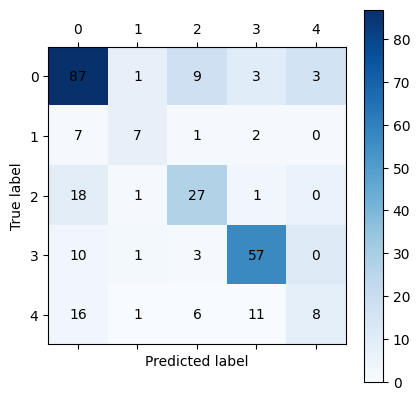

In [26]:
plot_confusion_matrix_multi(y_test_dis, bbc.predict(X_test_std))

## XGBClassifier

In [27]:
xgb = make_xgb_model(X_train_std, y_train_dis, X_test_std, y_test_dis)

[23:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "eval_metrics", "scale_pos_weight" } are not used.

score:              precision    recall  f1-score   support

           0       0.83      0.83      0.83       138
           1       0.83      0.45      0.59        11
           2       0.64      0.63      0.64        46
           3       0.78      0.89      0.83        74
           4       0.17      0.09      0.12        11

    accuracy                           0.77       280
   macro avg       0.65      0.58      0.60       280
weighted avg       0.76      0.77      0.76       280



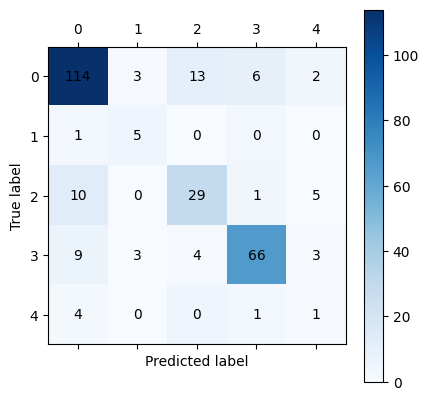

In [28]:
plot_confusion_matrix_multi(y_test_dis, xgb.predict(X_test_std))

## SVC 分类器

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


def make_svc_model(X_train, y_train, X_test, y_test):
    svc = SVC(
        kernel="rbf",
        gamma="auto",
        C=1,
        decision_function_shape="ovr",
        random_state=SEED,
        class_weight="balanced",
    )
    svc.fit(X_train, y_train)
    print(f"score:{classification_report(y_test,svc.predict(X_test))}")
    return svc

In [30]:
svm = make_svc_model(X_train_std, y_train_dis, X_test_std, y_test_dis)

score:              precision    recall  f1-score   support

           0       0.90      0.56      0.69       138
           1       0.27      0.55      0.36        11
           2       0.64      0.59      0.61        46
           3       0.69      0.74      0.71        74
           4       0.16      0.73      0.26        11

    accuracy                           0.62       280
   macro avg       0.53      0.63      0.53       280
weighted avg       0.75      0.62      0.65       280



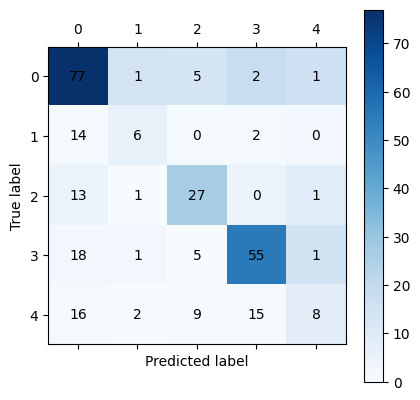

In [31]:
plot_confusion_matrix_multi(y_test_dis, svm.predict(X_test_std))

In [32]:
# GridSearch
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf", "poly", "sigmoid"],
}

grid = GridSearchCV(
    SVC(
        random_state=SEED,
        class_weight="balanced",
    ),
    param_grid,
    refit=True,
    verbose=2,
)
grid.fit(X_train_std, y_train_dis)
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

precision_score: 0.6464821733937567
recall_score: 0.6433927999145391
score:               precision    recall  f1-score   support

           0       0.87      0.80      0.84       138
           1       0.67      0.55      0.60        11
           2       0.62      0.65      0.64        46
           3       0.76      0.85      0.80        74
           4       0.31      0.36      0.33        11

    accuracy                           0.76       280
   macro avg       0.65      0.64      0.64       280
weighted avg       0.77      0.76      0.77       280



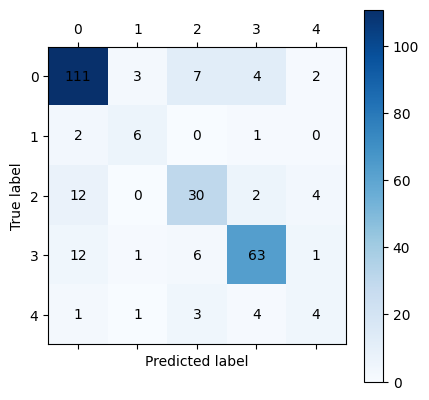

In [33]:
# 验证精度和召回率
from sklearn.metrics import precision_score, recall_score

y_pred = grid.predict(X_test_std)
print(f"precision_score: {precision_score(y_test_dis, y_pred, average='macro')}")
print(f"recall_score: {recall_score(y_test_dis, y_pred, average='macro')}")
print(f"score: {classification_report(y_test_dis, y_pred)}")

# 绘制混淆矩阵
plot_confusion_matrix_multi(y_test_dis, y_pred)